# FFN's milestone project 2 : Predicting heart disease
Part of this code is taken (and modified from the original) from the DUDL course by Mike X Cohen.

course url : udemy.com/course/deeplearning_x/?couponCode=202305

project author : Chen Cohen Gershon

In [1]:
# libraries:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import pandas as pd

<ipython-input-1-bc5b88522209>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Load the data set and clean it

In [2]:
# load the data set using the url:
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataset = pd.read_csv(url,sep=',',header=None)
dataset.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
dataset

# binerize the last column:
dataset['result']= (dataset.iloc[:,-1:] > 0).astype(float)

# data contain some ?'s; replace with NaN and drop those rows
dataset = dataset.replace('?',np.nan).dropna()

# # describe the data( shows statstics on the data like mean excetra)
# dataset.describe()

# z-score the non-categorical columns
cols2zscore = dataset.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE', 'result'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(dataset[c]) # force to numeric (addresses some data-format issues)
  dataset[c] = (d - d.mean())/d.std(ddof=1)

# put the data into data loader's

In [3]:
# separte the data and the labels:
dataT = torch.tensor(dataset.iloc[:, :-2].values).float()
labelsT = torch.tensor(dataset.iloc[:, -1:].values).float()

print( dataT.shape, labelsT.shape)

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=50)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
dataT.shape

torch.Size([297, 13]) torch.Size([297, 1])


torch.Size([297, 13])

# create the model:

In [4]:
# create a class for the model:
class HeartDnet(nn.Module):

  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,64)

    ### hidden layers
    self.hidden1 = nn.Linear(64,64)
    self.hidden2 = nn.Linear(64,48)

    ### output layer
    self.output = nn.Linear(48,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.hidden1(x) )
    x = F.relu( self.hidden2(x) )
    return self.output(x)

In [5]:
# function to create the model:
def createTheModel():

  # model instance
  net = HeartDnet()
  # loss function
  lossfun = nn.BCEWithLogitsLoss()
  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=.001)

  return net, lossfun, optimizer

In [6]:
net, lossfun, optim = createTheModel()
yHat = net(dataT)
yHat.shape

torch.Size([297, 1])

In [7]:
from tqdm.notebook import tqdm

def trainTheModle():

  # create the model:
  net, lossfun, optim = createTheModel()

  # define number of epochs:
  numEpochs = 50

  # define losse, acc:
  lossesTrain = torch.zeros(numEpochs)
  trainAcc = []
  testAcc  = []


  for epochi in tqdm(range(numEpochs)):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optim.zero_grad()
      loss.backward()
      optim.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = (yHat > 0) == y                    # booleans (false/true)
      matchesNumeric = matches.float()              # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    lossesTrain[epochi] = np.mean(batchLoss)

    # test forward pass
    Xtest, ytest = test_loader.dataset.tensors
    yHat_t = net(Xtest)

    # test accuracy
    testAcc.append( 100*torch.mean( ((yHat_t > 0 ) == ytest).float() ) )

  return lossesTrain, trainAcc, testAcc

In [8]:
# train the model
lossesTrain, trainAcc, testAcc = trainTheModle()

  0%|          | 0/50 [00:00<?, ?it/s]

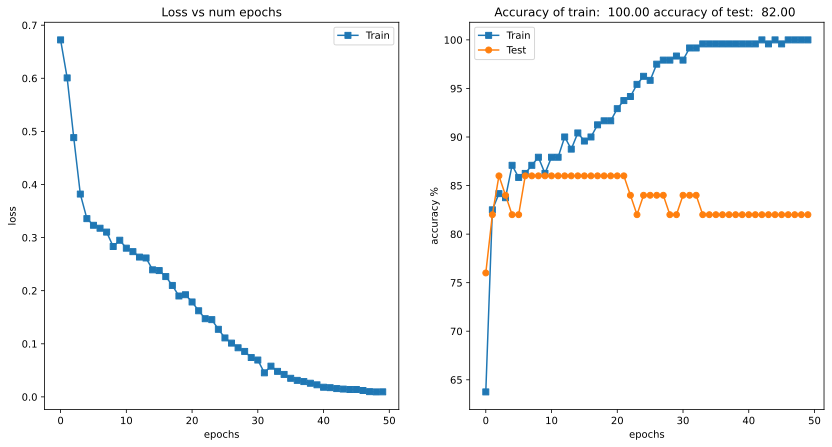

In [10]:
# plot's:

fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(lossesTrain, 's-')
ax[0].set_title('Loss vs num epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(['Train', 'Test'])


ax[1].plot(trainAcc, 's-')
ax[1].plot(testAcc, 'o-')
ax[1].set_title(f'Accuracy of train: {trainAcc[-1] : .2f} accuracy of test: {testAcc[-1] : .2f} ')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy %')
ax[1].legend(['Train', 'Test'])

# plt.tight_layout()
plt.show()
